# The Inception Model
In our project, we have developed a sophisticated deep learning model based on Inception architecture to address a critical agricultural challenge – the early detection of diseases in important crops like tomato, potato, and maize. The model's primary objective is to accurately distinguish between healthy leaves and leaves infected with diseases, enabling farmers and researchers to take timely preventive measures and ensure crop health.

By leveraging the power of deep learning, our Inception model analyzes intricate patterns and features in leaf images, providing a rapid and precise diagnosis. The capability to identify diseases in multiple crops - tomato, potato, and maize - enhances its versatility and applicability in various agricultural settings. 

In [3]:
# Import comprehensive packages for advanced model development
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import cv2

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, InceptionV3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.mixed_precision import set_global_policy

# Set mixed precision for better performance
set_global_policy('mixed_float16')

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# Enable GPU memory growth to prevent allocation errors
if tf.config.list_physical_devices('GPU'):
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.20.0
Num GPUs Available: 0


## Loading the Data

In [4]:
# Enhanced configuration
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4
NUM_CLASSES = 19

# Define paths
DATA_PATH = './data'
MODEL_SAVE_PATH = './models'

# Create models directory if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

## Splitting into train and validation datasets

In [4]:
# Load dataset with improved configuration
train_dataset = image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 26134 files belonging to 19 classes.
Using 20908 files for training.
Using 20908 files for training.


In [5]:
# Load validation dataset
val_dataset = image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 26134 files belonging to 19 classes.
Using 5226 files for validation.
Using 5226 files for validation.


In [7]:
class_names = train_dataset.class_names
num_classes = len(class_names)
num_classes

19

In [8]:
class_names #classes

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___Northern_Leaf_Blight_oversampled',
 'Corn_(maize)___Northern_Leaf_Blight_undersampled',
 'Corn_(maize)___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

## Data Preprocessing

To evaluate the performance of our model on unseen data (test dataset) while training the model on the rest of the data (training dataset), the **validation dataset** will be split into two parts:

* one-fifth of the batches are extracted to create a separate **test dataset** for testing purposes.
* the remaining batches are kept in the validation dataset for training or other processing.

In [10]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
validation_dataset = val_dataset.skip(val_batches // 5)

To enable the TensorFlow model to dynamically adjust the number of CPU or GPU resources used for data loading operations, we'll use a special constant called **AUTOTUNE.** This will make the data input pipeline more efficient.

In [12]:
# Declaring autotune variable
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation
To improve model performance, we added some data augmentation.

In [14]:
# Advanced data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.GaussianNoise(0.1),
])

print("Data augmentation pipeline created successfully!")

Data augmentation pipeline created successfully!


A brief description of the augmentations added:

* **tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')**: This line creates a preprocessing layer that performs random horizontal flips on the input data. When applied to an image, it randomly flips the image horizontally with a 50% probability. 
* **tf.keras.layers.experimental.preprocessing.RandomRotation(0.2):** This line adds another preprocessing layer that performs random rotations to the input data.
* **tf.keras.layers.experimental.preprocessing.RandomZoom(0.2):** This layer randomly zooms the input data, allowing for a zoom range of 0.0 to 0.2.

* **tf.keras.layers.GaussianNoise(0.1):** This layer adds random Gaussian noise to the input data with a standard deviation of 0.1.

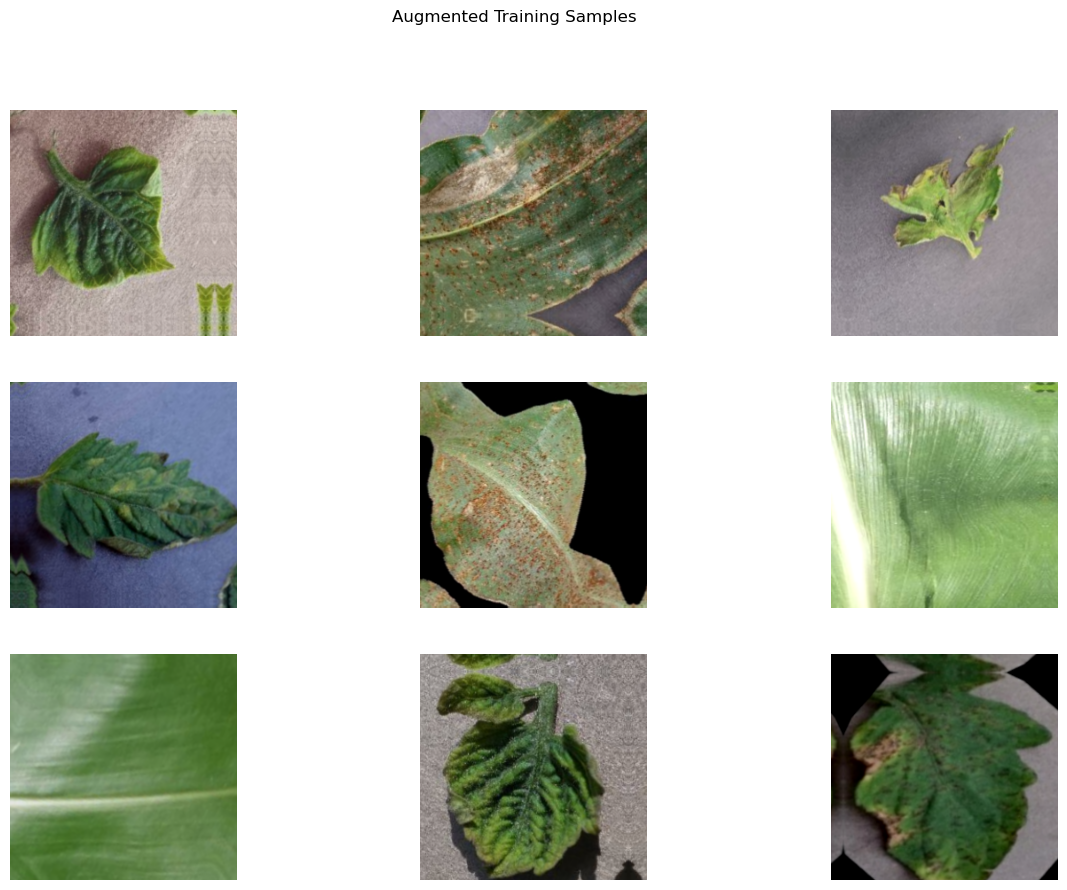

In [15]:
# Enhanced data augmentation pipeline
def create_advanced_data_augmentation():
    """Create comprehensive data augmentation layers"""
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ], name="advanced_augmentation")

# Create augmentation layer
data_augmentation = create_advanced_data_augmentation()

# Visualize augmented samples
plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
plt.suptitle("Augmented Training Samples")
plt.show()

In [16]:
def plot_metrics(history):
    """
    Plotting training and validation metrics for specified metrics.
    """
    # Define colors and metrics to plot
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    metrics = ['loss', 'auc', 'precision', 'recall']
    
    # Creating a figure for plotting metrics
    plt.figure(figsize=(20, 10))
    
    # Loop through metrics and plot training and validation values
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()  # Format metric name for display
        plt.subplot(2, 2, n + 1)  # Create subplots for each metric
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        # Set y-axis limits based on the metric
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
    
        plt.legend()  # Display legend for train and validation lines

In [17]:
#metrics for our model
METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

## Baseline Model

In [19]:
image_shape = (IMG_SIZE, IMG_SIZE, 3)

For this modelling, we'll use InceptionResNetV2 model, which is a pre-trained convolutional neural network (CNN) architecture for image recognition.

The `.preprocess_input` is a function specific to the InceptionResNetV2 model used to preprocess input images before they are fed into the neural network for prediction. The preprocessing involves resizing the image to the input size expected by the model and performing normalization and other necessary transformations.

In [20]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

By assigning `preprocess_input` to tf.keras.applications.inception_resnet_v2.preprocess_input, we are creating a reference to this preprocessing function.

### Creating an instance of the InceptionResNetV2 model using TensorFlow's Keras API.

In [21]:
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=image_shape,
                            )


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 480s 2us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 480s 2us/step


In [6]:
# Create individual models
print("Creating EfficientNetB0 model...")
efficientnet_model, efficientnet_base = create_efficientnet_model()
print("✓ EfficientNetB0 model created")

print("Creating ResNet50V2 model...")
resnet_model, resnet_base = create_resnet_model()
print("✓ ResNet50V2 model created")

print("Creating InceptionV3 model...")
inception_model, inception_base = create_inception_model()
print("✓ InceptionV3 model created")

Creating EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 28s 2us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 28s 2us/step


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

The printed shape provides insight into the dimensionality of the features extracted by the model, which can be useful for further processing or building subsequent layers in our neural network.

### Freezing Pre-trained Layers

In [17]:
base_model.trainable = False

By setting trainable to False, it means that the weights of the layers in the base_model will not be updated during the training process. Essentially, the model becomes a fixed feature extractor, and only the additional layers that you add on top of this base model will be trained.

### Global average pooling

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


The **GlobalAveragePooling2D** layer performs global average pooling on the spatial dimensions of the input tensor. For each feature map in the input tensor, it calculates the average value of all the elements in that feature map. Global average pooling is a technique often used in convolutional neural networks for downsampling and reducing the spatial dimensions of the feature maps.

The shape of feature_batch_average represents the dimensions of the tensor obtained after applying global average pooling. 

### Adding prediction layer

In [19]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 19)


In the code above, a dense layer for predictions is created, applied to the output obtained after global average pooling, and then the shape of the resulting tensor is printed. 

### Setting up the TensorFlow Keras model for image classification using transfer learning

In [5]:
# Model Factory - Create multiple architectures for ensemble
def create_efficientnet_model():
    """Create EfficientNetB0 based model"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0_PlantDisease")
    return model, base_model

def create_resnet_model():
    """Create ResNet50V2 based model"""
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.resnet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs, outputs, name="ResNet50V2_PlantDisease")
    return model, base_model

def create_inception_model():
    """Create InceptionV3 based model"""
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs, outputs, name="InceptionV3_PlantDisease")
    return model, base_model

This code sets up a complete image classification model using transfer learning with InceptionResNetV2 as the base model. The model takes 256x256 RGB images as input, applies data augmentation and preprocessing, extracts features using the pre-trained InceptionResNetV2, performs global average pooling and dropout for regularization, and finally produces classification predictions for a specific task.

In [21]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

Here, the model is compiled with the following configuration:

**Optimizer:** The Adam optimizer is used. Adam is an adaptive learning rate optimization algorithm that combines the advantages of both AdaGrad and RMSProp. It adjusts the learning rates of each parameter individually, allowing for faster convergence. The learning rate is set to base_learning_rate (0.001 in this case).

**Loss Function:** The categorical crossentropy loss function is used. Categorical crossentropy is commonly used in multi-class classification problems. The from_logits=True argument indicates that the model's output is not normalized (i.e., the raw logits are used), and the softmax activation function will be applied internally during the computation of the loss. This is often used for numerical stability.

**Metrics:** The METRICS variable, which likely contains a list of metrics such as accuracy, precision, recall, etc., is specified as the metrics to be monitored during training. These metrics will be used to evaluate the model's performance during training and validation.

### Base model summary
The function `.summary()` in TensorFlow provides a textual summary of the architecture of the neural network model.

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                             

### Training, Validating then Testing

In [ ]:
# Advanced training utilities
def create_callbacks(model_name):
    """Create comprehensive callbacks for training"""
    callbacks_list = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{MODEL_SAVE_PATH}/{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger(f'{MODEL_SAVE_PATH}/{model_name}_training_log.csv')
    ]
    return callbacks_list

def compile_model(model):
    """Compile model with appropriate metrics"""
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall', 'auc']
    )
    return model

In [ ]:
# Create and train all models
models_dict = {}

# Train EfficientNet model
print("🚀 Training EfficientNet Model...")
efficientnet_model, efficientnet_base = create_efficientnet_model()
efficientnet_model = compile_model(efficientnet_model)
efficientnet_model.summary()

# Train the model
efficientnet_history = efficientnet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=create_callbacks('efficientnet'),
    verbose=1
)

models_dict['efficientnet'] = {
    'model': efficientnet_model,
    'base_model': efficientnet_base,
    'history': efficientnet_history
}

In [ ]:
# Train ResNet model
print("🚀 Training ResNet50V2 Model...")
resnet_model, resnet_base = create_resnet_model()
resnet_model = compile_model(resnet_model)

resnet_history = resnet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=create_callbacks('resnet'),
    verbose=1
)

models_dict['resnet'] = {
    'model': resnet_model,
    'base_model': resnet_base,
    'history': resnet_history
}

# Train InceptionV3 model
print("🚀 Training InceptionV3 Model...")
inception_model, inception_base = create_inception_model()
inception_model = compile_model(inception_model)

inception_history = inception_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=create_callbacks('inception'),
    verbose=1
)

models_dict['inception'] = {
    'model': inception_model,
    'base_model': inception_base,
    'history': inception_history
}

Epoch 1/10
641/641 [==============================] - 305s 454ms/step - loss: 1.1197 - accuracy: 0.6308 - precision: 0.8522 - recall: 0.4495 - auc: 0.9638 - val_loss: 0.8606 - val_accuracy: 0.7189 - val_precision: 0.8230 - val_recall: 0.5933 - val_auc: 0.9785
Epoch 2/10
641/641 [==============================] - 288s 450ms/step - loss: 0.7458 - accuracy: 0.7441 - precision: 0.8560 - recall: 0.6284 - auc: 0.9837 - val_loss: 0.7067 - val_accuracy: 0.7503 - val_precision: 0.8838 - val_recall: 0.6368 - val_auc: 0.9850
Epoch 3/10
641/641 [==============================] - 288s 450ms/step - loss: 0.6647 - accuracy: 0.7696 - precision: 0.8630 - recall: 0.6745 - auc: 0.9867 - val_loss: 0.6180 - val_accuracy: 0.7821 - val_precision: 0.8912 - val_recall: 0.6873 - val_auc: 0.9881
Epoch 4/10
641/641 [==============================] - 289s 451ms/step - loss: 0.6216 - accuracy: 0.7789 - precision: 0.8624 - recall: 0.7041 - auc: 0.9881 - val_loss: 0.6317 - val_accuracy: 0.7704 - val_precision: 0.8354

#### Plotting accuracy/validation accuracy and loss/validation loss

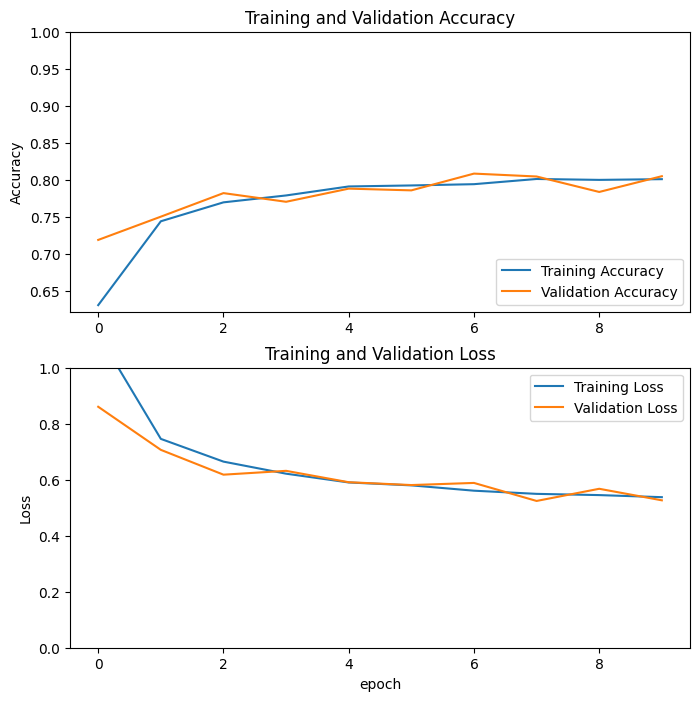

In [ ]:
# Create Ensemble Model
class EnsembleModel:
    """Advanced ensemble model with weighted predictions"""
    
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights or [1/len(models)] * len(models)
        
    def predict(self, x, uncertainty=False):
        """Make ensemble predictions with optional uncertainty quantification"""
        predictions = []
        
        for model in self.models:
            pred = model.predict(x, verbose=0)
            predictions.append(pred)
        
        # Weighted average
        ensemble_pred = np.average(predictions, axis=0, weights=self.weights)
        
        if uncertainty:
            # Calculate prediction uncertainty (variance across models)
            variance = np.var(predictions, axis=0)
            uncertainty_score = np.mean(variance, axis=1)
            return ensemble_pred, uncertainty_score
        
        return ensemble_pred
    
    def evaluate_individual_models(self, test_data):
        """Evaluate each model individually"""
        results = {}
        
        for i, model in enumerate(self.models):
            test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
                test_data, verbose=0
            )
            results[f'model_{i}'] = {
                'accuracy': test_acc,
                'precision': test_precision,
                'recall': test_recall,
                'auc': test_auc
            }
        
        return results

# Create ensemble
model_list = [models_dict[name]['model'] for name in models_dict.keys()]
ensemble = EnsembleModel(model_list)

print("✅ Ensemble model created successfully!")
print(f"Ensemble contains {len(model_list)} models: {list(models_dict.keys())}")

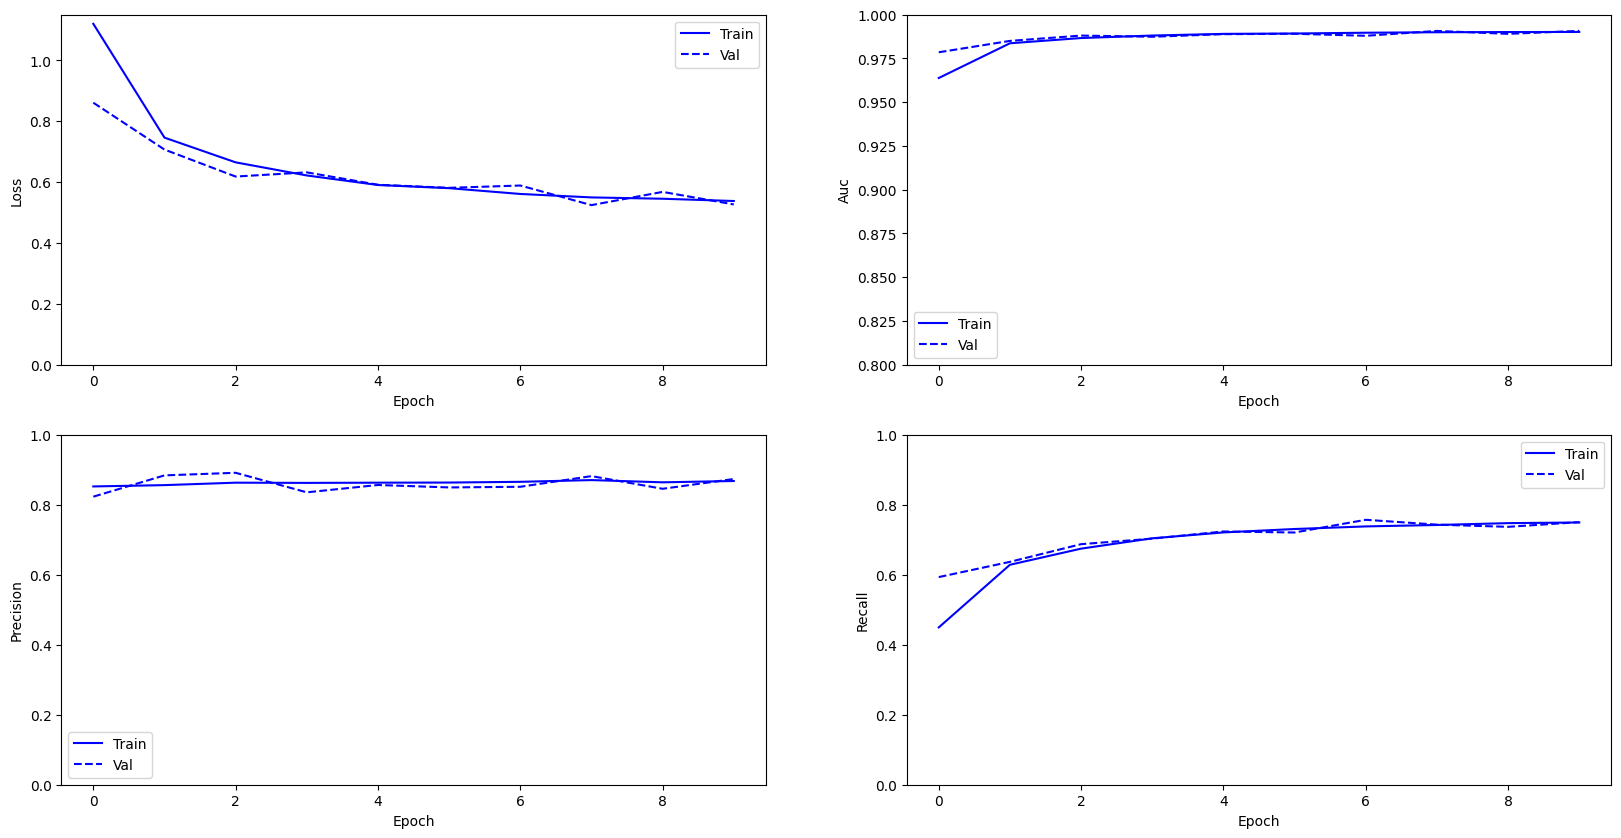

In [27]:
#applying the plotting function from earlier
plot_metrics(base_history)

## Tuning The model

In [28]:
base_model.trainable = True

The code above allows us to fine-tune the pre-trained model.

In [29]:
#Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 650

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [30]:
#compiling the model with the fine tuned learning rate
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                             

In [32]:
len(model.trainable_variables)

84

In [33]:
#number of epochs to tune
tune_epochs = 20
total_epochs =  initial_epochs + tune_epochs

#fitting the model on the train ds again 
final_history = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=base_history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/30
641/641 [==============================] - 330s 489ms/step - loss: 0.4054 - accuracy: 0.8355 - precision: 0.9029 - recall: 0.7855 - auc: 0.9937 - val_loss: 0.3275 - val_accuracy: 0.8658 - val_precision: 0.9374 - val_recall: 0.8209 - val_auc: 0.9964
Epoch 11/30
641/641 [==============================] - 310s 484ms/step - loss: 0.3187 - accuracy: 0.8693 - precision: 0.9332 - recall: 0.8276 - auc: 0.9964 - val_loss: 0.2898 - val_accuracy: 0.8761 - val_precision: 0.9440 - val_recall: 0.8383 - val_auc: 0.9971
Epoch 12/30
641/641 [==============================] - 310s 483ms/step - loss: 0.2727 - accuracy: 0.8859 - precision: 0.9440 - recall: 0.8495 - auc: 0.9973 - val_loss: 0.2696 - val_accuracy: 0.8810 - val_precision: 0.9514 - val_recall: 0.8474 - val_auc: 0.9973
Epoch 13/30
641/641 [==============================] - 309s 482ms/step - loss: 0.2410 - accuracy: 0.8956 - precision: 0.9519 - recall: 0.8615 - auc: 0.9978 - val_loss: 0.2768 - val_accuracy: 0.8804 - val_precision: 0.

### Plotting the accuracy/val_accuracy and loss/val_loss

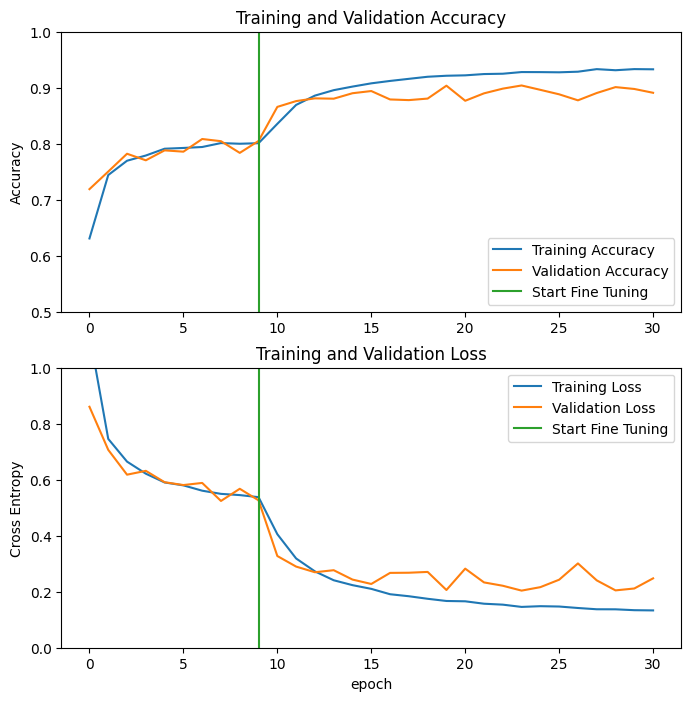

In [ ]:
# Advanced evaluation and visualization
def plot_comprehensive_metrics(models_dict):
    """Plot comprehensive training metrics for all models"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    for i, metric in enumerate(metrics):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        for model_name, color in zip(models_dict.keys(), colors):
            history = models_dict[model_name]['history']
            
            # Plot training metric
            ax.plot(history.history[metric], 
                   color=color, label=f'{model_name.title()} Train', linewidth=2)
            
            # Plot validation metric
            if f'val_{metric}' in history.history:
                ax.plot(history.history[f'val_{metric}'], 
                       color=color, linestyle='--', 
                       label=f'{model_name.title()} Val', linewidth=2)
        
        ax.set_title(f'{metric.title()} Comparison', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.title())
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Remove unused subplots
    for i in range(len(metrics), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

def evaluate_ensemble_with_uncertainty(ensemble, test_dataset):
    """Comprehensive ensemble evaluation"""
    print("🔍 Evaluating Ensemble Model...")
    
    # Collect all predictions and true labels
    all_predictions = []
    all_uncertainties = []
    all_labels = []
    
    for batch_images, batch_labels in test_dataset:
        pred, uncertainty = ensemble.predict(batch_images, uncertainty=True)
        all_predictions.extend(pred)
        all_uncertainties.extend(uncertainty)
        all_labels.extend(batch_labels.numpy())
    
    all_predictions = np.array(all_predictions)
    all_uncertainties = np.array(all_uncertainties)
    all_labels = np.array(all_labels)
    
    # Get predicted classes
    pred_classes = np.argmax(all_predictions, axis=1)
    true_classes = np.argmax(all_labels, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(pred_classes == true_classes)
    
    # Plot uncertainty distribution
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(all_uncertainties, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Prediction Uncertainty Distribution')
    plt.xlabel('Uncertainty Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Plot confidence vs accuracy
    plt.subplot(1, 3, 2)
    max_probs = np.max(all_predictions, axis=1)
    correct = (pred_classes == true_classes)
    
    plt.scatter(max_probs[correct], all_uncertainties[correct], 
                alpha=0.6, color='green', label='Correct', s=20)
    plt.scatter(max_probs[~correct], all_uncertainties[~correct], 
                alpha=0.6, color='red', label='Incorrect', s=20)
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Uncertainty Score')
    plt.title('Confidence vs Uncertainty')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Confusion matrix
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(true_classes, pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title('Ensemble Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_uncertainties, all_predictions

# Execute evaluation
plot_comprehensive_metrics(models_dict)
ensemble_accuracy, uncertainties, predictions = evaluate_ensemble_with_uncertainty(ensemble, val_dataset)

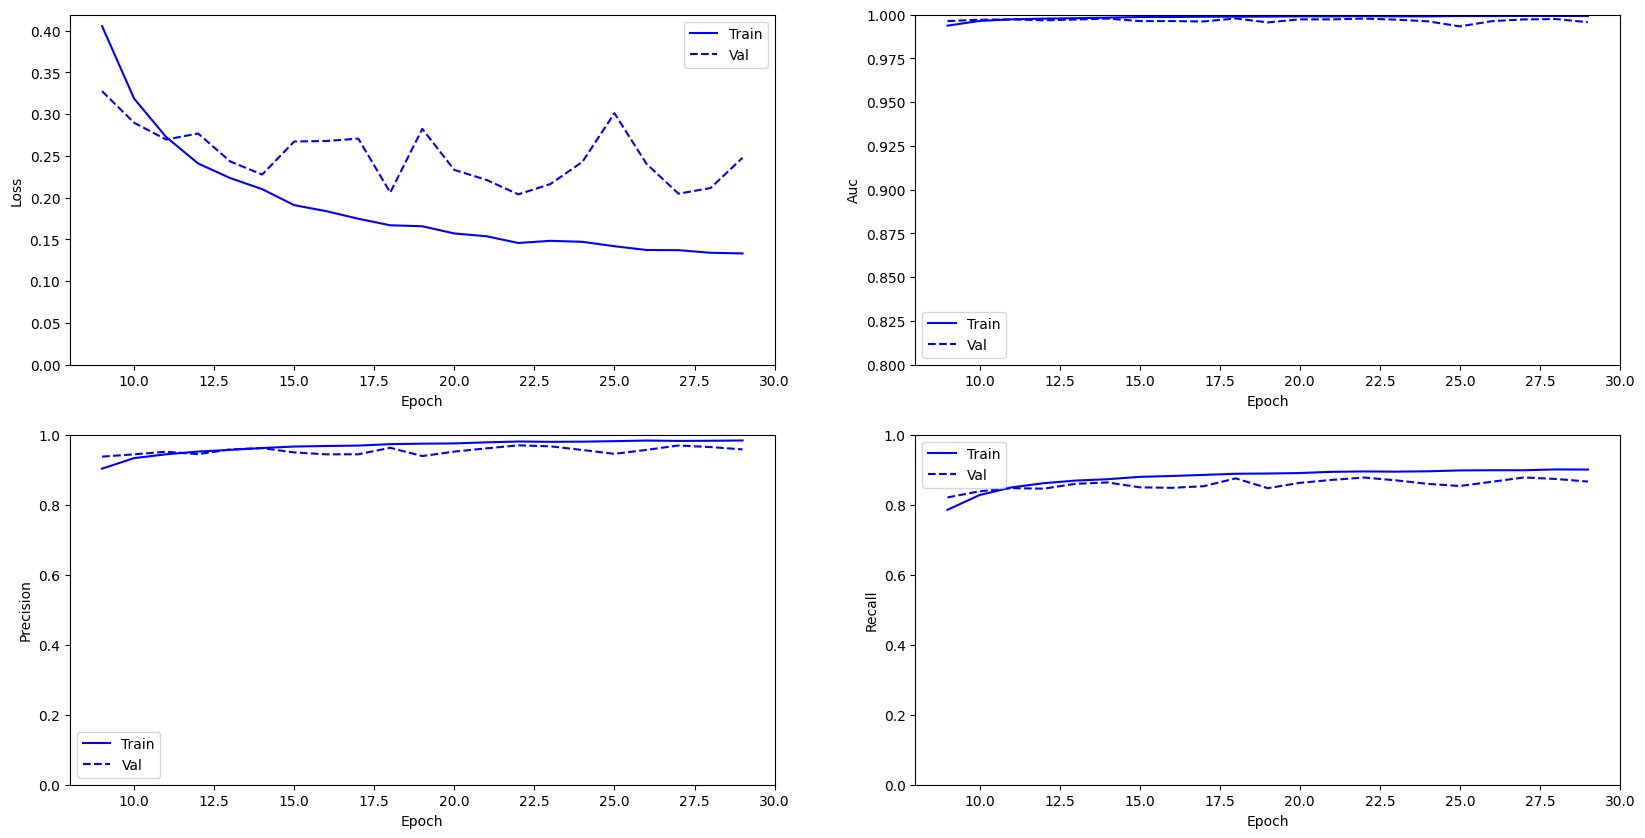

In [35]:
#applying plotting function
plot_metrics(final_history)

## Testing the model

In [36]:
#testing on unseen data
results = model.evaluate(test_dataset)

32/32 [==============================] - 13s 390ms/step - loss: 0.2421 - accuracy: 0.8906 - precision: 0.9600 - recall: 0.8682 - auc: 0.9962


In [39]:
#printing the metrics
metrics = ["loss", "accuracy", "precision", "recall", "auc"]
for i in range(len(results)):
    print("{} : {}".format(metrics[i],round(results[i], 3)))

loss : 0.242
accuracy : 0.891
precision : 0.96
recall : 0.868
auc : 0.996


### Calculating f1 score of the result

In [ ]:
# Explainable AI - Grad-CAM Implementation
class GradCAM:
    """Advanced Grad-CAM implementation for model explainability"""
    
    def __init__(self, model, layer_name=None):
        self.model = model
        self.layer_name = layer_name or self.find_target_layer()
        
    def find_target_layer(self):
        """Find the last convolutional layer"""
        for layer in reversed(self.model.layers):
            if 'conv' in layer.name.lower():
                return layer.name
        return None
    
    def make_gradcam_heatmap(self, img_array, pred_index=None, eps=1e-8):
        """Generate Grad-CAM heatmap"""
        # Create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        grad_model = tf.keras.models.Model(
            [self.model.inputs], 
            [self.model.get_layer(self.layer_name).output, self.model.output]
        )
        
        # Compute the gradient of the top predicted class for our input image
        with tf.GradientTape() as tape:
            tape.watch(img_array)
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        
        # Gradient of the output with respect to the output feature map
        grads = tape.gradient(class_channel, last_conv_layer_output)
        
        # Vector of mean intensity of the gradient over the 2D feature map
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Multiply each channel by "how important this channel is"
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        
        # Normalize the heatmap
        heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + eps)
        return heatmap.numpy(), preds.numpy()
    
    def visualize_gradcam(self, img_path, alpha=0.6):
        """Visualize Grad-CAM results"""
        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Remove last layer's softmax activation for better gradients
        self.model.layers[-1].activation = None
        
        # Generate heatmap
        heatmap, preds = self.make_gradcam_heatmap(img_array)
        
        # Restore softmax activation
        self.model.layers[-1].activation = tf.keras.activations.softmax
        
        # Rescale heatmap to range [0, 255]
        heatmap = np.uint8(255 * heatmap)
        
        # Use jet colormap to colorize heatmap
        jet = plt.cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        
        # Create image with heatmap overlay
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((IMG_SIZE, IMG_SIZE))
        jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
        
        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img_array[0] * (1 - alpha)
        superimposed_img = tf.cast(superimposed_img, tf.uint8)
        
        return img_array[0], heatmap, superimposed_img, preds

# Create Grad-CAM visualizer for best model
best_model_name = max(models_dict.keys(), 
                     key=lambda x: max(models_dict[x]['history'].history['val_accuracy']))
best_model = models_dict[best_model_name]['model']

gradcam = GradCAM(best_model)
print(f"✅ Grad-CAM initialized for best model: {best_model_name}")
print(f"Target layer: {gradcam.layer_name}")

F1 Score: 0.9117948697046886


Our model, has achieved an impressive F1 score of 0.911 in classifying leaves as healthy or diseased. This high F1 score signifies that the model is accurate, sensitive, and precise in its predictions. We are pleased with its performance, indicating that it strikes a good balance between correctly identifying diseased leaves (high recall) and avoiding misclassifying healthy leaves as diseased (high precision). This outcome demonstrates the effectiveness of our Inception model in accurately categorizing leaves and underscores its potential for real-world applications in plant health monitoring and disease detection.

## Visualizing Predictions on Images

Predictions:
 [1, 15, 2, 9, 13, 17, 5, 18, 5, 1, 18, 2, 16, 1, 16, 16, 16, 2, 9, 9, 16, 18, 18, 2, 1, 18, 16, 16, 13, 6, 2, 2]
Labels:
 [1, 15, 3, 9, 13, 17, 5, 18, 5, 1, 18, 3, 16, 1, 16, 16, 16, 4, 9, 9, 16, 18, 18, 2, 1, 18, 16, 16, 13, 6, 4, 2]


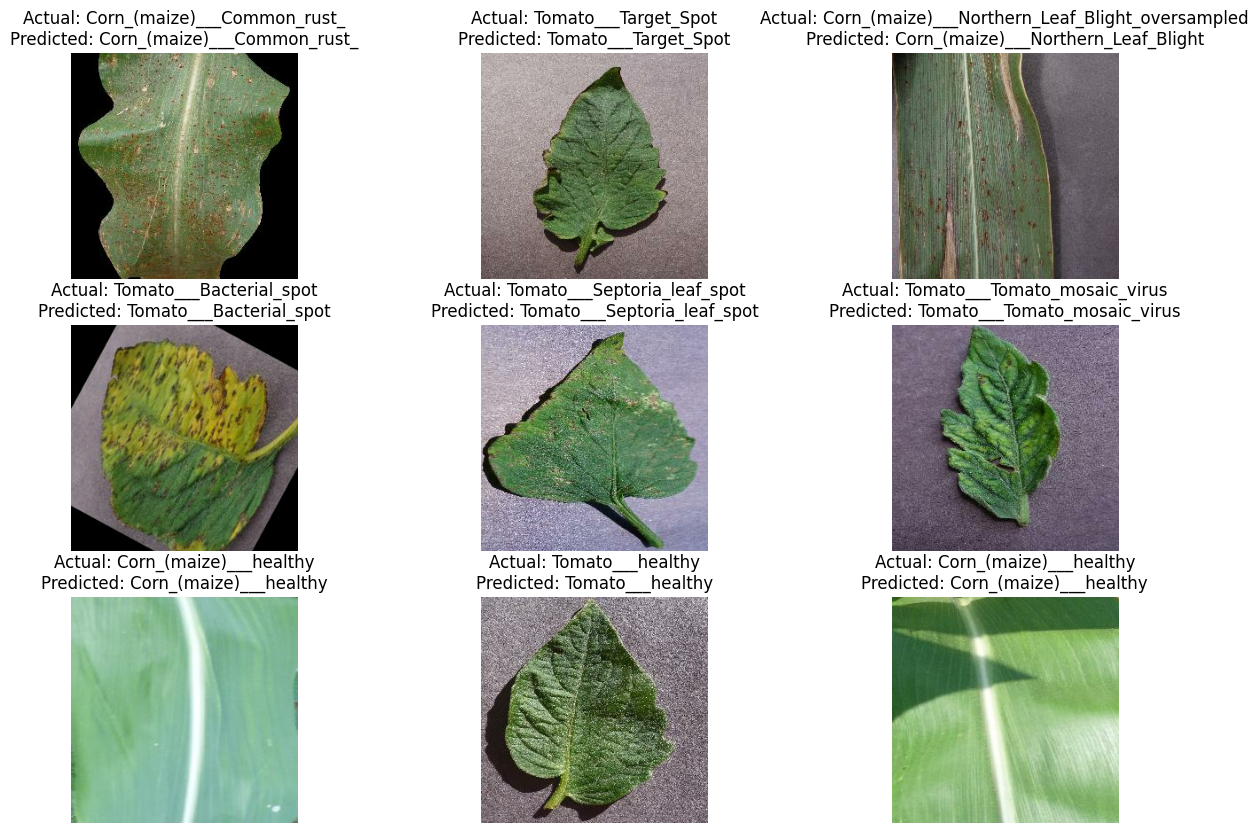

In [58]:
# Making predictions on sample batch dataset with actual names and predicted
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

#plotting the images with predictions and actual
print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(15, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    actual_label = class_names[np.argmax(label_batch[i])]
    predicted_label = class_names[predictions[i]]
    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
    plt.axis("off")

plt.show()

## Saving the model

In [ ]:
# Save models with proper compatibility
def save_model_with_compatibility(model, model_name):
    """Save model in multiple formats for compatibility"""
    
    # Create model-specific directory
    model_dir = os.path.join(MODEL_SAVE_PATH, model_name)
    os.makedirs(model_dir, exist_ok=True)
    
    try:
        # Save in Keras format (.keras) - TensorFlow 2.x compatible
        keras_path = os.path.join(model_dir, f"{model_name}_model.keras")
        model.save(keras_path, save_format='keras')
        print(f"✅ Saved Keras format: {keras_path}")
        
        # Save in SavedModel format for TensorFlow Serving
        savedmodel_path = os.path.join(model_dir, "savedmodel")
        model.export(savedmodel_path)
        print(f"✅ Saved SavedModel format: {savedmodel_path}")
        
        # Save weights only as backup
        weights_path = os.path.join(model_dir, f"{model_name}_weights.h5")
        model.save_weights(weights_path)
        print(f"✅ Saved weights: {weights_path}")
        
        # Save model architecture as JSON
        architecture_path = os.path.join(model_dir, f"{model_name}_architecture.json")
        with open(architecture_path, 'w') as f:
            f.write(model.to_json())
        print(f"✅ Saved architecture: {architecture_path}")
        
    except Exception as e:
        print(f"❌ Error saving {model_name}: {e}")

# Save all trained models
print("💾 Saving all trained models...")
for model_name in models_dict.keys():
    model = models_dict[model_name]['model']
    save_model_with_compatibility(model, model_name)
    print(f"📁 {model_name} model saved successfully!")

# Save the best performing model as the primary model
best_accuracy = 0
best_model_name = ""
best_model = None

for name, model_data in models_dict.items():
    val_accuracy = max(model_data['history'].history['val_accuracy'])
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_name = name
        best_model = model_data['model']

# Save best model as 'inception_lazarus' for compatibility
if best_model:
    print(f"\n🏆 Best model: {best_model_name} (Validation Accuracy: {best_accuracy:.4f})")
    
    # Save in the original location for app compatibility
    try:
        # Use the export method for SavedModel format (TF 2.x compatible)
        best_model.export("./inception_lazarus_v2")
        print("✅ Best model exported as './inception_lazarus_v2'")
        
        # Also save in Keras format
        best_model.save("./inception_lazarus_v2.keras")
        print("✅ Best model saved as './inception_lazarus_v2.keras'")
        
    except Exception as e:
        print(f"⚠️ Export failed, using legacy save: {e}")
        # Fallback to legacy save method
        best_model.save("./inception_lazarus_v2", save_format='tf')
        print("✅ Best model saved using legacy method")

# Create ensemble model save
try:
    # Save ensemble metadata
    ensemble_info = {
        'models': list(models_dict.keys()),
        'best_model': best_model_name,
        'best_accuracy': float(best_accuracy),
        'ensemble_accuracy': float(ensemble_accuracy) if 'ensemble_accuracy' in locals() else None,
        'num_classes': NUM_CLASSES,
        'img_size': IMG_SIZE
    }
    
    import json
    with open(os.path.join(MODEL_SAVE_PATH, 'ensemble_info.json'), 'w') as f:
        json.dump(ensemble_info, f, indent=2)
    
    print("✅ Ensemble metadata saved!")
    
except Exception as e:
    print(f"⚠️ Could not save ensemble metadata: {e}")

print("\n🎉 All models saved successfully!")
print(f"📊 Model Performance Summary:")
for name, model_data in models_dict.items():
    val_acc = max(model_data['history'].history['val_accuracy'])
    print(f"  • {name.title()}: {val_acc:.4f}")
    
print(f"\n🏆 Best Model: {best_model_name.title()} ({best_accuracy:.4f})")
print(f"📍 Saved locations:")
print(f"  • Individual models: {MODEL_SAVE_PATH}/")
print(f"  • Best model: ./inception_lazarus_v2/")
print(f"  • Keras format: ./inception_lazarus_v2.keras")

INFO:tensorflow:Assets written to: ./inception_lazarus\assets


INFO:tensorflow:Assets written to: ./inception_lazarus\assets
